In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x :'%3.f' % x)
np.printoptions(suppress=True, precision=3)

from lightgbm import LGBMClassifier, early_stopping, plot_tree, plot_importance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, log_loss
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split

## Carregar os dados

In [2]:
df_wine = pd.read_csv('./wine.csv')

In [3]:
df_wine.info()

<class 'pandas.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         21000 non-null  float64
 1   volatile_acidity      21000 non-null  float64
 2   citric_acid           21000 non-null  float64
 3   residual_sugar        21000 non-null  float64
 4   chlorides             21000 non-null  float64
 5   free_sulfur_dioxide   21000 non-null  float64
 6   total_sulfur_dioxide  21000 non-null  float64
 7   density               21000 non-null  float64
 8   pH                    21000 non-null  float64
 9   sulphates             21000 non-null  float64
 10  alcohol               21000 non-null  float64
 11  quality               21000 non-null  int64  
dtypes: float64(11), int64(1)
memory usage: 1.9 MB


In [4]:
df_wine.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0             12                 1            1               2          0   
1             10                 1            0               2          0   
2              7                 1            0               4          0   
3             10                 0            0               2          0   
4              8                 1            0               3          0   

   free_sulfur_dioxide  total_sulfur_dioxide  density  pH  sulphates  alcohol  \
0                   10                    47        1   3          1        9   
1                    5                    16        1   3          1        8   
2                    5                    14        1   4          1       11   
3                   34                    48        1   3          1       10   
4                    6                    11        1   3          0       11   

   quality  
0        3  
1        3  
2        3  
3        3  
4        3

In [5]:
df_wine.tail(10)

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
20990             12                 1            1              59   
20991             10                 1            1              54   
20992             13                 1            1              51   
20993             13                 1            1              53   
20994             13                 1            1              45   
20995             10                 1            1              50   
20996             10                 1            1              54   
20997             13                 0            1              52   
20998              7                 1            1              25   
20999              9                 1            1              34   

       chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density  pH  \
20990          0                  232                   396        1   3   
20991          0                   62                   205        1   4   
20992          0                  197                   172        1   3   
20993          0                   93                   191        1   3   
20994          0                  215                   253        1   3   
20995          0                  115                   182        1   3   
20996          0                   62                   205        1   4   
20997          0                   63                   274        1   3   
20998          0                  180                   295        1   3   
20999          0                  129                   290        1   3   

       sulphates  alcohol  quality  
20990          1       12        9  
20991          1       10        9  
20992          1       12        9  
20993          1       10        9  
20994          1       11        9  
20995          1       12        9  
20996          1       10        9  
20997          2        9        9  
20998          2       13        9  
20999          1       13        9

In [6]:
df_wine.describe()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count          21000             21000        21000           21000   
mean              10                 1            1              31   
std                2                 0            0              19   
min                4                 0            0               1   
25%                8                 0            0              10   
50%               10                 1            1              38   
75%               12                 1            1              47   
max               16                 2            2              66   

       chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    pH  \
count      21000                21000                 21000    21000 21000   
mean           0                  129                   229        1     3   
std            0                   77                   100        0     0   
min            0                    1                     6        1     3   
25%            0                   45                   150        1     3   
50%            0                  146                   240        1     3   
75%            0                  194                   312        1     3   
max            1                  289                   440        1     4   

       sulphates  alcohol  quality  
count      21000    21000    21000  
mean           1       11        6  
std            0        1        2  
min            0        8        3  
25%            1       10        4  
50%            1       11        6  
75%            1       12        8  
max            2       15        9

## EDA

In [7]:
# Distribuição das variáveis numéricas
numerical_cols = df_wine.drop(columns=['quality']).columns

# Visualizar distribuição das variáveis numéricas

for col in numerical_cols:
    fig = px.histogram(df_wine, x=col, nbins=20, title=f'Distribuição de {col}')
    fig.show()

In [8]:
df_count = df_wine['quality'].value_counts().reset_index()
df_count.columns = ['quality','contagem']

# Distribuição da variável target
fig = px.bar(df_count, x='quality',y='contagem', title=f'Distribuição da variável target', color='quality')
fig.show()

In [9]:
# Analisando relação entre variáveis numéricas e target?
for col in numerical_cols:
    fig = px.box(df_wine, x='quality',y=col,title=f'Relação entre {col} e quality', color='quality')
    fig.show()

In [10]:
# Matriz de Correlação
corr_matrix = df_wine.corr()

fig = px.imshow(
    corr_matrix,
    color_continuous_scale='armyrose',
    zmin=-1,
    zmax=1
)

fig.update_traces(
    text=corr_matrix,
    texttemplate='%{text:.2f}',
    textfont_size=9
)

fig.update_layout(
    width=1000,
    height=600,
    title_font=dict(size=14),
    font=dict(size=10)
)

fig.show()

## Preparação dos dados

In [11]:
X = df_wine.drop(columns=['quality'])
y = df_wine['quality']

In [12]:
# Separar entre treino, validação e teste
X_train, X_val_test, y_train, y_val_test = train_test_split(X,y,test_size=0.5,random_state=51)
X_val, X_test, y_val, y_test = train_test_split(X_val_test,y_val_test, test_size=0.5,random_state=51)

## Treinar o modelo LightGBM usando Otimização Bayesiana

In [13]:
# Definir a grade de hiperparâmetros a serem otimizados

grade_hiperparametros = {
    'num_leaves': (10,100),
    'max_depth': (3,15),
    'learning_rate': (0.01,0.3),
    'min_data_in_leaf': (5,50),
    'feature_fraction':(0.5,0.8)
}

In [14]:
# Criar função para o modelo LightGBM

def lightgbm_evaluate(num_leaves, max_depth, learning_rate, min_data_in_leaf, feature_fraction):
    model = LGBMClassifier(
        num_leaves=int(num_leaves),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        min_data_in_leaf=int(min_data_in_leaf),
        feature_fraction=feature_fraction
    )

    # Treinar o modelo com early stopping

    model.fit(
        X_train,
        y_train,
        eval_metric='multi_logloss',
        eval_set=[(X_val,y_val)],
        callbacks=[early_stopping(5)]
    )

    # Métrica de avaliação
    best_score = model.best_score_['valid_0']['multi_logloss']

    return -best_score


In [15]:
# Otmização Bayesiana
optimizer = BayesianOptimization(
    f=lightgbm_evaluate,
    pbounds=grade_hiperparametros,
    random_state=51
)

optimizer.maximize(init_points=5, n_iter=2)

|   iter    |  target   | num_le... | max_depth | learni... | min_da... | featur... |
-------------------------------------------------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] feature_fraction is set=0.5852638996220869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5852638996220869
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] feature_fraction is set=0.5852638996220869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5852638996220869
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 10500, number of used 

In [16]:
# Melhor combinação de hiperparâmetros
print(f'Melhores hiperparâmetros encontrados: {optimizer.max}')

Melhores hiperparâmetros encontrados: {'target': np.float64(-1.324908228630708), 'params': {'num_leaves': np.float64(78.03636916817017), 'max_depth': np.float64(11.28883280574527), 'learning_rate': np.float64(0.1656313090746314), 'min_data_in_leaf': np.float64(37.13653286663127), 'feature_fraction': np.float64(0.6584597258844583)}}


## Validar Resultados

In [17]:
# Treinar modelo com melhores hiperparâmetros
best_params = optimizer.max['params']

best_model = LGBMClassifier(
    num_leaves=int(best_params['num_leaves']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    min_data_in_leaf=int(best_params['min_data_in_leaf']),
    feature_fraction=best_params['feature_fraction'],
    n_estimators=100
)

# Treinar o modelo
best_model.fit(X_train,y_train)

[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.6584597258844583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6584597258844583
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.6584597258844583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6584597258844583
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 11
[LightGBM] [Info] Start training from score -1.924149
[LightGBM] [Info] Start training from score -1.937942
[LightGBM] [Info] Start training from score -1.9432

LGBMClassifier(feature_fraction=np.float64(0.6584597258844583),
               learning_rate=np.float64(0.1656313090746314), max_depth=11,
               min_data_in_leaf=37, num_leaves=78)

In [18]:
# Fazer predições

y_pred = best_model.predict(X_test)
y_pred

[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.6584597258844583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6584597258844583


array([8, 8, 9, ..., 3, 9, 6], shape=(5250,))

In [19]:
# Fazer a predição de probabilidade
y_pred_proba = best_model.predict_proba(X_test)
y_pred_proba

[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.6584597258844583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6584597258844583


array([[9.18515950e-02, 2.56022172e-01, 4.86505822e-02, ...,
        7.06461412e-02, 3.29750705e-01, 2.01977936e-01],
       [1.46202141e-01, 5.90246017e-02, 3.74261846e-02, ...,
        1.78838337e-01, 3.66364762e-01, 2.11271703e-01],
       [1.14668001e-01, 1.63356922e-01, 4.09084624e-03, ...,
        1.26926322e-01, 1.17965063e-01, 4.68516059e-01],
       ...,
       [9.17825933e-01, 2.50531823e-02, 1.65091607e-02, ...,
        7.81019174e-03, 2.25779101e-02, 1.01378212e-02],
       [1.92373794e-01, 1.70110529e-01, 8.52348123e-03, ...,
        7.11796705e-02, 2.75128731e-01, 2.81571839e-01],
       [5.16321797e-05, 1.11275730e-04, 4.43011900e-03, ...,
        1.84787990e-01, 5.52691854e-02, 1.82554366e-05]], shape=(5250, 7))

In [20]:
# Relatório de classificação
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           3       0.45      0.55      0.50       741
           4       0.45      0.49      0.47       728
           5       0.65      0.54      0.59       764
           6       0.60      0.63      0.61       748
           7       0.50      0.40      0.45       732
           8       0.50      0.45      0.47       756
           9       0.49      0.54      0.51       781

    accuracy                           0.51      5250
   macro avg       0.52      0.51      0.51      5250
weighted avg       0.52      0.51      0.51      5250



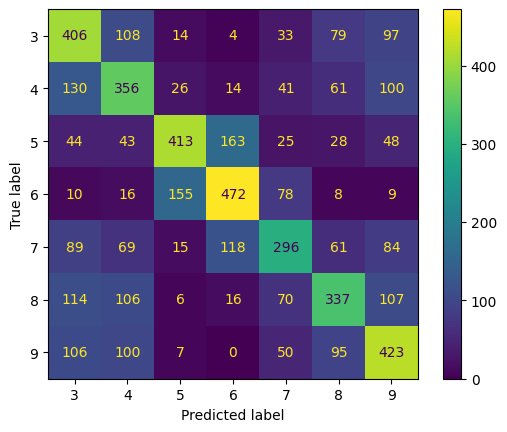

In [21]:
# Matriz de Confusão

cm = confusion_matrix(y_test,y_pred)
fig = ConfusionMatrixDisplay(cm, display_labels=best_model.classes_)
fig.plot()

In [22]:
# Log loss
log_loss(y_test,y_pred_proba)

1.344237235400965

## Interpretabilidade

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

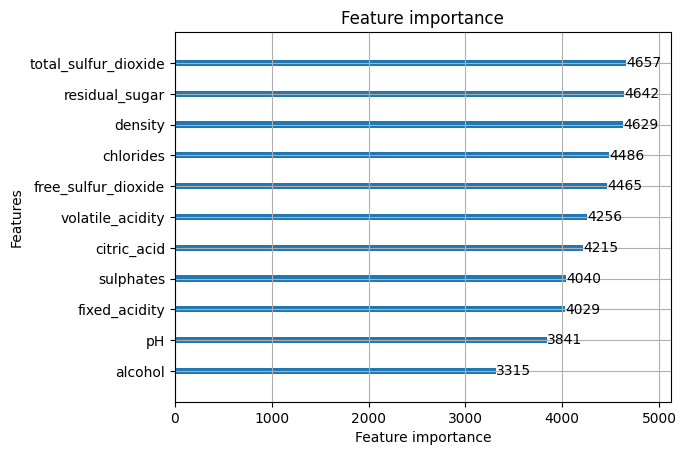

In [23]:
plot_importance(best_model)

<Axes: >

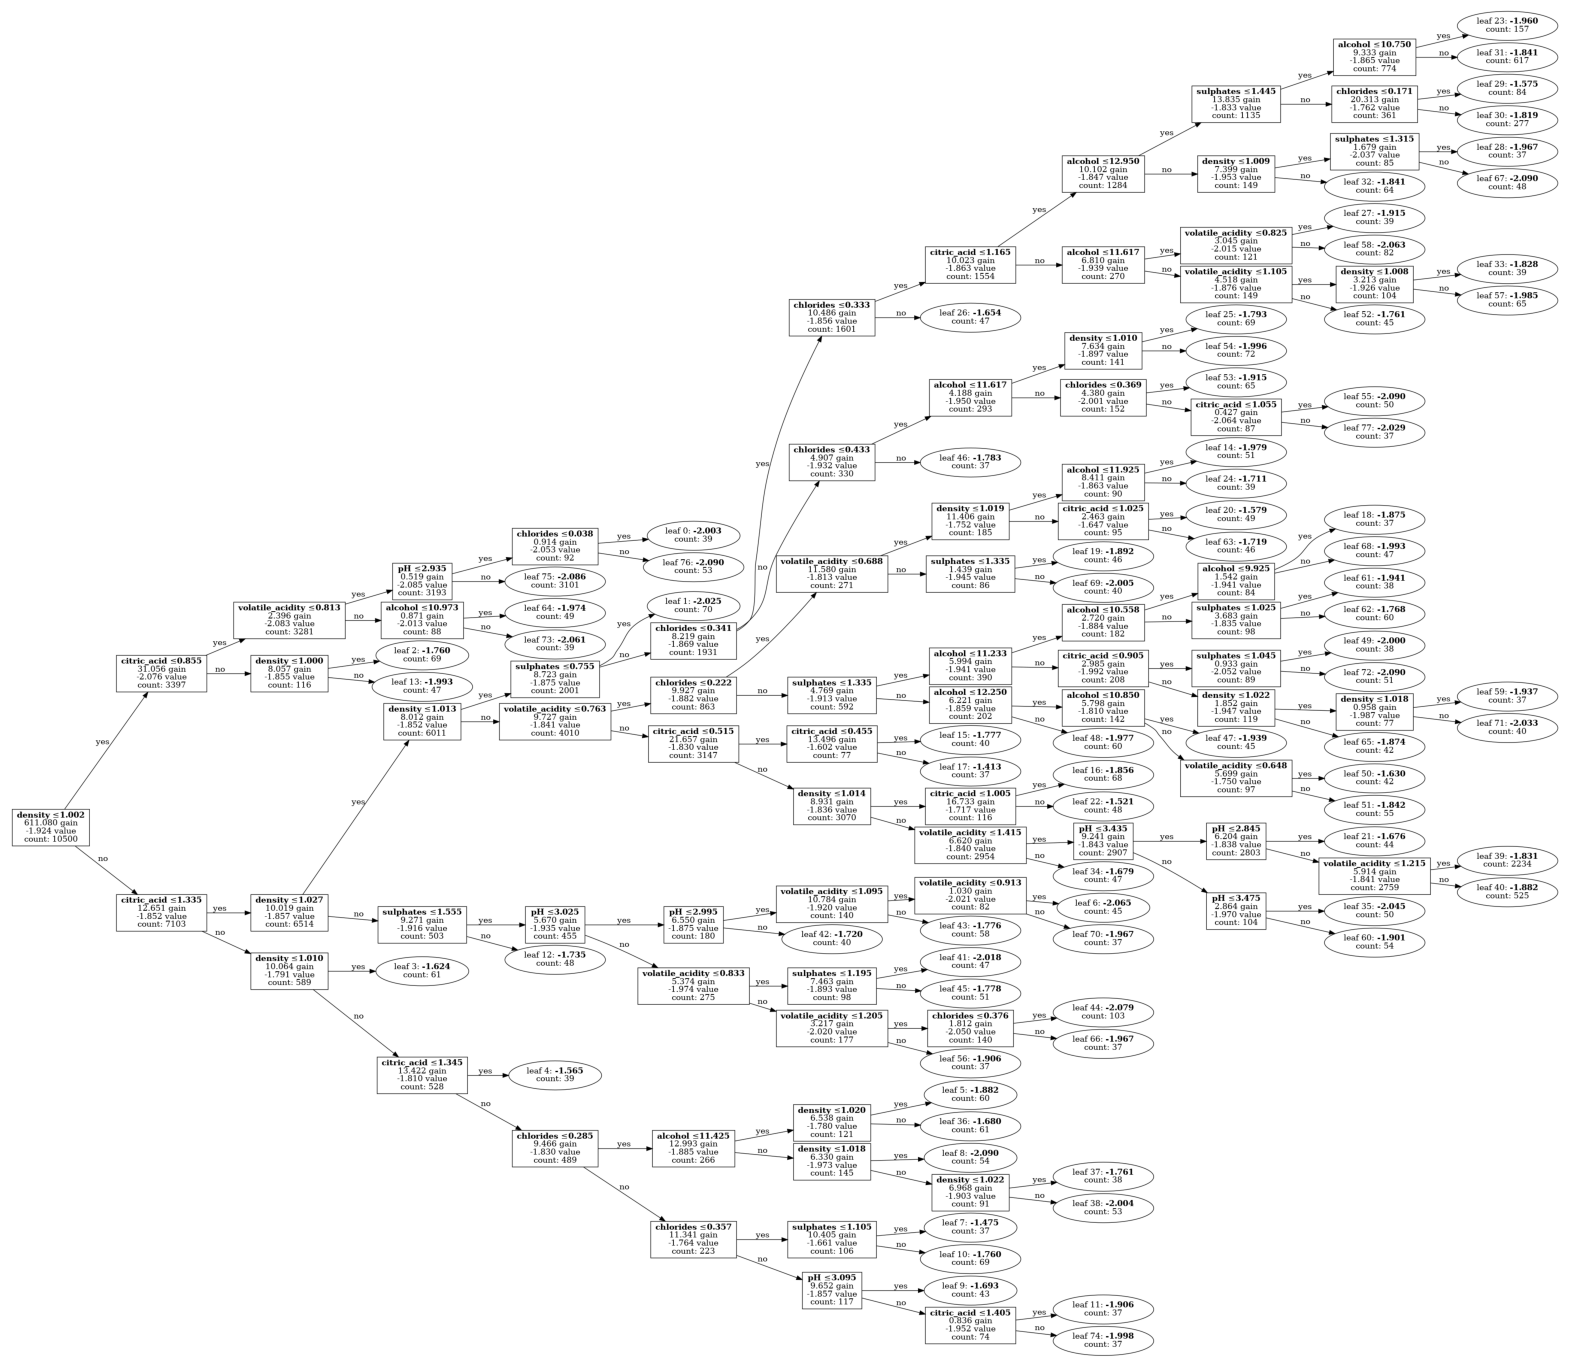

In [25]:
# Visualizar árvore de decisão
plot_tree(best_model, figsize=(20,20), show_info=['split_gain','internal_value','internal_count','leaf_count'])